In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.append('./../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../')
import mvpose.data.transform as tfm

root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()

from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)

Using TensorFlow backend.


UMPM


(2,)


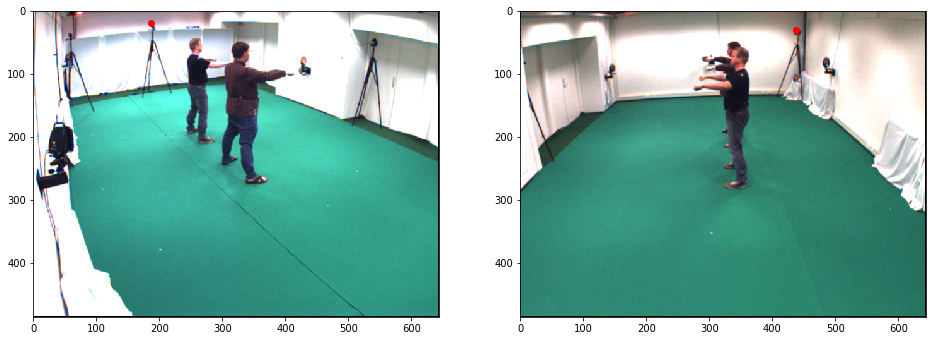

In [4]:
from mvpose.geometry import stereo

e2, e1 = stereo.get_epipoles(Calib[1], Calib[2])

Im1 = X[1][0]; Im2 = X[2][0]
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.imshow(Im1)
ax.scatter(e2[0], e2[1], color='red')

ax = fig.add_subplot(122)
ax.imshow(Im2)
ax.scatter(e1[0], e1[1], color='red')

plt.show()